# Bilinear loss functions

In [14]:
import patches
import lettertask
import torch.optim as optim
import torch
import torch.nn as nn
import numpy as np
import plotnine as gg
import lazytools_sflippl as lazytools
import torch.utils as utils
from tqdm import tqdm
import pandas as pd

In [2]:
similarity = patches.losses.BilinearSimilarity()

In [3]:
criterion = patches.losses.ContrastiveLoss(similarity=similarity)

In [4]:
criterion

ContrastiveLoss(
  (similarity): BilinearSimilarity()
)

In [5]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[5, 5],
    change_probability=[0.05, 0.5],
    samples=10000,
    seed=1001
)

In [6]:
cts = patches.data.Contrastive1DTimeSeries(cbm.to_array())
cdl = utils.data.DataLoader(cts, batch_size=8, drop_last=True)
ce = patches.networks.LinearScaffold(1, data=cts)

In [7]:
ideal = np.array([1]*5+[0]*5)/np.sqrt(5)

In [8]:
optimizer = optim.Adam(ce.parameters(), lr=0.01)
angles = []
loss_traj = []
running_loss = 0
for epoch in tqdm(range(10)):
    running_loss = 0
    for i, data in enumerate(cdl):
        if i<len(cdl):
            if i % 10 == 0:
                est = list(ce.parameters())[0].detach().numpy()
                angles.append(np.matmul(ideal, est.T)/np.sqrt(np.matmul(est, est.T)))
            optimizer.zero_grad()
            code = ce(data)
            loss = criterion(code)
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0

100%|██████████| 10/10 [00:28<00:00,  2.77s/it]


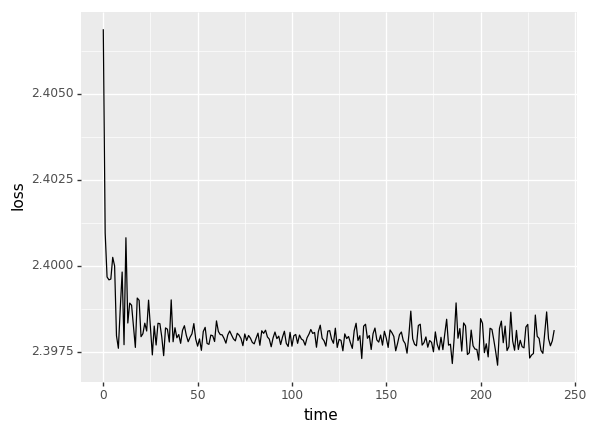

<ggplot: (8774416985664)>

In [9]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line() + 
    gg.xlab('time') + 
    gg.ylab('loss'))

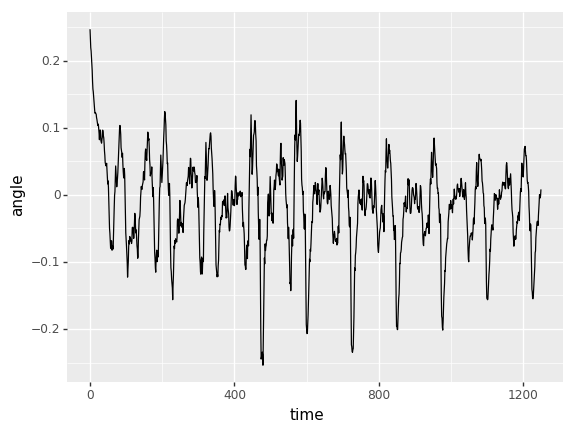

<ggplot: (8774253509156)>

In [10]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(angles)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line() + 
    gg.xlab('time') + 
    gg.ylab('angle'))

What is the angle contrast between these two loss functions? Because of the random initialization component, we iterate each method ten times.

In [29]:
angle_dfs = []
loss_dfs = []
criterion = patches.losses.ContrastiveLoss(similarity=similarity)
with tqdm(total=2*10*10) as pbar:
    for iteration in range(10):
        ce = patches.networks.LinearScaffold(1, data=cts)
        optimizer = optim.Adam(ce.parameters(), lr=0.01)
        angles = []
        loss_traj = []
        running_loss = 0
        for epoch in range(10):
            running_loss = 0
            for i, data in enumerate(cdl):
                if i<len(cdl):
                    if i % 10 == 0:
                        est = list(ce.parameters())[0].detach().numpy()
                        angles.append(np.matmul(ideal, est.T)/np.sqrt(np.matmul(est, est.T)))
                    optimizer.zero_grad()
                    code = ce(data)
                    loss = criterion(code)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss
                    if i % 50 == 49:
                        loss_traj.append(running_loss.detach().numpy()/50)
                        running_loss = 0
            pbar.update(1)
        df_angle = lazytools.array_to_dataframe(np.array(angles))\
                            .rename(columns={'dim0': 'steps', 'array': 'angle'})
        df_angle['criterion'] = np.array('bilinear')
        df_angle['iteration'] = np.array(iteration)
        df_loss = lazytools.array_to_dataframe(np.array(loss_traj))\
                           .rename(columns={'dim0': 'steps', 'array': 'loss'})
        df_loss['criterion'] = np.array('bilinear')
        df_loss['iteration'] = np.array(iteration)
        angle_dfs.append(df_angle)
        loss_dfs.append(df_loss)
    criterion = patches.losses.ContrastiveLoss(loss=nn.MSELoss())
    for iteration in range(10):
        ce = patches.networks.LinearScaffold(1, data=cts)
        optimizer = optim.Adam(ce.parameters(), lr=0.01)
        angles = []
        loss_traj = []
        running_loss = 0
        for epoch in range(10):
            running_loss = 0
            for i, data in enumerate(cdl):
                if i<len(cdl):
                    if i % 10 == 0:
                        est = list(ce.parameters())[0].detach().numpy()
                        angles.append(np.matmul(ideal, est.T)/np.sqrt(np.matmul(est, est.T)))
                    optimizer.zero_grad()
                    code = ce(data)
                    loss = criterion(code)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss
                    if i % 50 == 49:
                        loss_traj.append(running_loss.detach().numpy()/50)
                        running_loss = 0
            pbar.update(1)
        df_angle = lazytools.array_to_dataframe(np.array(angles))\
                            .rename(columns={'dim0': 'steps', 'array': 'angle'})
        df_angle['criterion'] = np.array('mse')
        df_angle['iteration'] = np.array(iteration)
        df_loss = lazytools.array_to_dataframe(np.array(loss_traj))\
                           .rename(columns={'dim0': 'steps', 'array': 'loss'})
        df_loss['criterion'] = np.array('mse')
        df_loss['iteration'] = np.array(iteration)
        angle_dfs.append(df_angle)
        loss_dfs.append(df_loss)

200it [10:18,  3.24s/it]


In [46]:
df_angle = pd.concat(angle_dfs, sort=False)
df_loss = pd.concat(loss_dfs, sort=False)

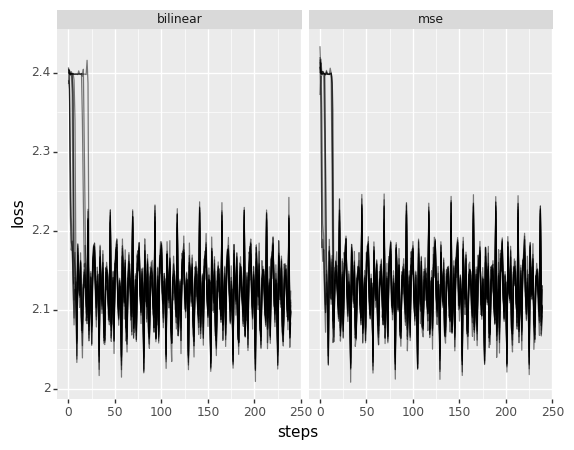

<ggplot: (-9223363262643851015)>

In [47]:
(gg.ggplot(df_loss, gg.aes(x='steps', y='loss', group='iteration')) +
    gg.facet_wrap('criterion') + 
    gg.geom_line(alpha=.5))

In [48]:
df_angle['angle'] = abs(df_angle['angle'])
df_angle['steps'] += 1
df_angle['group'] = df_angle['iteration'].astype(str) + df_angle['criterion']

In [49]:
np.arange(100, 1000, 100)

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

/home/sflippl/.local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/sflippl/.local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/sflippl/.local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/sflippl/.local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


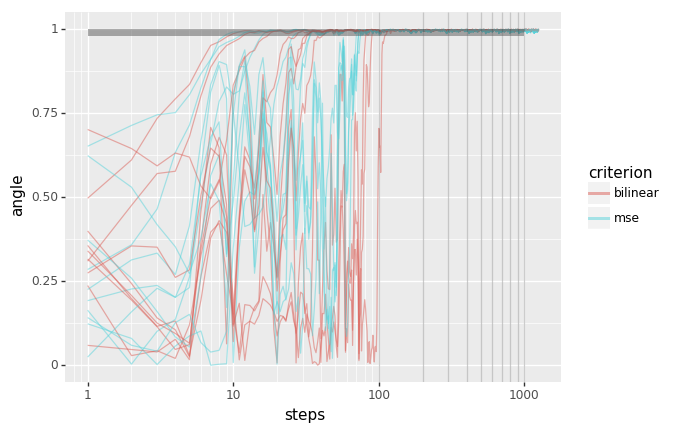

<ggplot: (-9223363262630674481)>

In [68]:
(gg.ggplot(df_angle, gg.aes(x='steps', y='angle', group='group', color='criterion')) +
    gg.geom_line(alpha=.5) + 
    gg.scale_x_log10() + 
    gg.geom_vline(xintercept=np.arange(100, 1100, 100), alpha=.2) + 
    gg.geom_rect(data=pd.DataFrame(),
                 mapping=gg.aes(xmin=1, xmax=1000, ymin=0.98, ymax=1),
                 inherit_aes=False, alpha=.5))

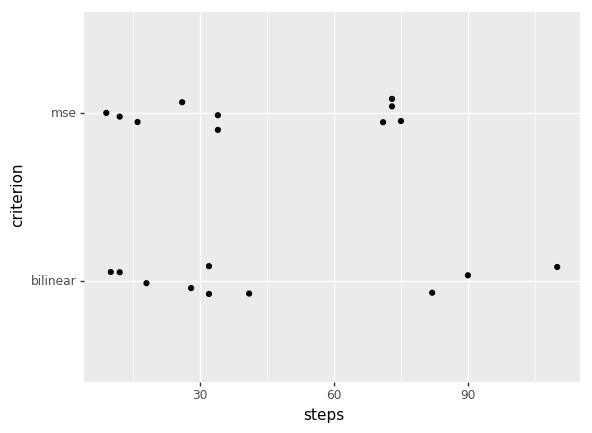

<ggplot: (-9223363262630648148)>

In [78]:
(gg.ggplot(
    df_angle[df_angle['angle']>=0.98]\
            .groupby(['criterion', 'iteration'])[['steps']]\
            .min()\
            .reset_index(),
    gg.aes(x='steps', y='criterion')) + 
    gg.geom_jitter(width=0, height=0.1)
)